In [0]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import os
import cv2 
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import shutil
import random 
from skimage.morphology import skeletonize

plt.rcParams["figure.figsize"] = (10,10)

ROOT = "/content/drive/My Drive/"

In [2]:
!pip install pytube3 --upgrade
from pytube import YouTube


In [0]:
# shutil.rmtree("videos")
os.mkdir("videos")

urls_filenames = [
                  ["https://www.youtube.com/watch?v=yZnPhZQaaOQ&feature=youtu.be", "unc"],
                  ["https://www.youtube.com/watch?v=0qFhTbxg210&feature=youtu.be", "wild_isloate"],
                  ["https://www.youtube.com/watch?v=FqH-ztxGrAc&feature=youtu.be", "egl"]
]

for i in urls_filenames:
    YouTube(i[0]).streams[0].download(filename = i[1])

!mv *.mp4 /content/videos/

In [0]:
def video_to_frames(video_path, new_folder_path):
    frames_paths = []
    try:
        os.mkdir(new_folder_path)
    except:
        shutil.rmtree(new_folder_path)
        os.mkdir(new_folder_path) 
    vidObj = cv2.VideoCapture(video_path)   
    success = 1
    count = 0
    while success: 
        success, image = vidObj.read() 
        fmt_name = new_folder_path + "/" + str(count)+ ".jpg"
        try:
            cv2.imwrite(fmt_name, image)
            frames_paths.append(fmt_name)
            count += 1
        except:
            pass 
    print ("saved ", count-1, " frames at ", new_folder_path)
    return frames_paths

In [14]:
shutil.rmtree("frames")
os.mkdir("frames")

videos_frame_folders = [
          ["videos/unc.mp4", "frames/unc"],
          ["videos/wild_isloate.mp4", "frames/wild"],
          ["videos/egl.mp4", "frames/egl"]
]

frames_paths = []

for i in videos_frame_folders:

    frames= video_to_frames(
                            video_path = i[0],
                            new_folder_path = i[1]
                            )
    frames_paths.append(frames)

saved  3375  frames at  frames/unc
saved  2962  frames at  frames/wild
saved  3124  frames at  frames/egl


In [0]:
def find_distance(vertices):
    x1 = vertices[0][0]
    x2 = vertices[1][0]
    y1 = vertices[0][1]
    y2 = vertices[1][1]

    dx = x2-x1

    dy = y2-y1

    distance = ((dx**2 + dy**2)**0.5)
    return distance

In [0]:
def read_and_shrink_image(image_path, shrink_factor = 2):
    raw_img = cv2.imread(image_path, 0) ## 0 means grayscale = 1 color channel 
    raw_img_small = cv2.resize(raw_img, (int(raw_img.shape[1]/shrink_factor), int(raw_img.shape[0]/shrink_factor)))
    return raw_img_small

def draw_circle(image, vertex, radius, thickness = 5):
    with_circle = cv2.circle(
                            image,                
                            vertex, 
                            radius = radius, 
                            color = (255, 255, 255),  ## (B, G, R) 
                            thickness = thickness)
    return with_circle


def crop_image(eroded_image, vertex):

    real_cropped= []
    
    x1 = vertex[0][0]
    x2 = vertex[1][0]
    y1 = vertex[0][1]
    y2 = vertex[1][1]

    real_crop = eroded_image[ y1:y2, x1:x2] ## cropping 
    return real_crop

def segment_worm(image, lower_gray = [0, 0, 10], higher_gray = [0, 0, 90]):
    img = (image).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_gray = np.array(lower_gray, np.uint8)
    upper_gray = np.array(higher_gray, np.uint8)
    mask_gray = cv2.inRange(hsv, lower_gray, upper_gray)
    img_res = cv2.bitwise_and(img, img, mask = mask_gray)
    img_color  = cv2.cvtColor(img_res, cv2.COLOR_HSV2BGR)
    img_gray  = cv2.cvtColor(img_res, cv2.COLOR_BGR2GRAY)
   
    return img_gray

def generate_skeleton_from_eroded_image(eroded_image):
    thresh_binary = threshold_image_np(eroded_image, 10, invert = False, final_value = 1 )
    vertices =find_head_and_tail(eroded_image)
    skeleton = skeletonize(thresh_binary).astype(np.float32)
    skeleton = skeleton *100
    for vertex in vertices:
        skeleton = draw_circle(skeleton,vertex,radius = 5, thickness = 1 )
    return skeleton

def erode_image(image,  kernel_size):
    
    kernel =  np.ones(kernel_size, np.uint8)
    eroded_image = cv2.erode(image, kernel)
    return eroded_image

def threshold_image_np(raw_img, upper_gray_threshold, invert = True, final_value = 255):  ## converts all pixels above upper_gray_threshold to 255 = white 
    
    if invert == True:
        ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  final_value, cv2.THRESH_BINARY_INV)
    else:
        ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  final_value, cv2.THRESH_BINARY)
    return thresh1

def find_worms_return_vertices(thresh_image, minimum_size = 50, padding = 20):

    rect_vertices = []
    contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # print(contours)
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if 0 in (x,y,w,h): ## skip invalid stuff 
            continue
        if w < minimum_size or h < minimum_size :  # skip if too small to be a worm
            continue
        w += padding 
        h+= padding 
        rect_vertices.append([(x - padding , y - padding ), (x+w, y+h)])
    return rect_vertices

def find_head_and_tail(cropped_gray_image): 
    vertices = []
    corners = np.int0(cv2.goodFeaturesToTrack(cropped_gray_image, maxCorners = 2,qualityLevel =  0.001, minDistance = 50)) 
    for i in corners: 
        x, y = i.ravel()
        vertices.append((x,y))
    return  vertices

def find_head_tail_distances_from_images(frames_paths, low_gray = 10 , high_gray = 125):

    distances = []
    imcount = 0
    for i in tqdm(frames_paths):
        
        image_path = i
        
        try:  ## skip if image path is not found for some reason
            raw_img_small = read_and_shrink_image(image_path, shrink_factor = 1)
            raw_img_small = cv2.blur(raw_img_small,(5,5)) 
            
        except:
            continue
        
        seg = segment_worm(raw_img_small, lower_gray = [0, 0, low_gray], higher_gray = [0, 0, high_gray])
        eroded_image = erode_image(seg, kernel_size = (5,5))
        thresh = threshold_image_np(eroded_image, upper_gray_threshold= 20, invert = False)
        # plt.imshow(thresh)
        # plt.show()

        vertices = find_worms_return_vertices(thresh, minimum_size = 20, padding = 10)
        
        if len(vertices)>1:
            continue

        vertices = vertices[0]

        eroded_image = crop_image(eroded_image, vertices)

        head_tail = find_head_and_tail(eroded_image)

        distance = find_distance(head_tail)

        
        distances.append(distance)

        # if distance < 100:
        #     line_image = generate_skeleton_from_eroded_image(eroded_image)
        #     plt.imshow(line_image)
        #     plt.show()
    return np.array(distances)
        

In [ ]:
distances_1 = find_head_tail_distances_from_images(frames_paths = frames_paths[0])

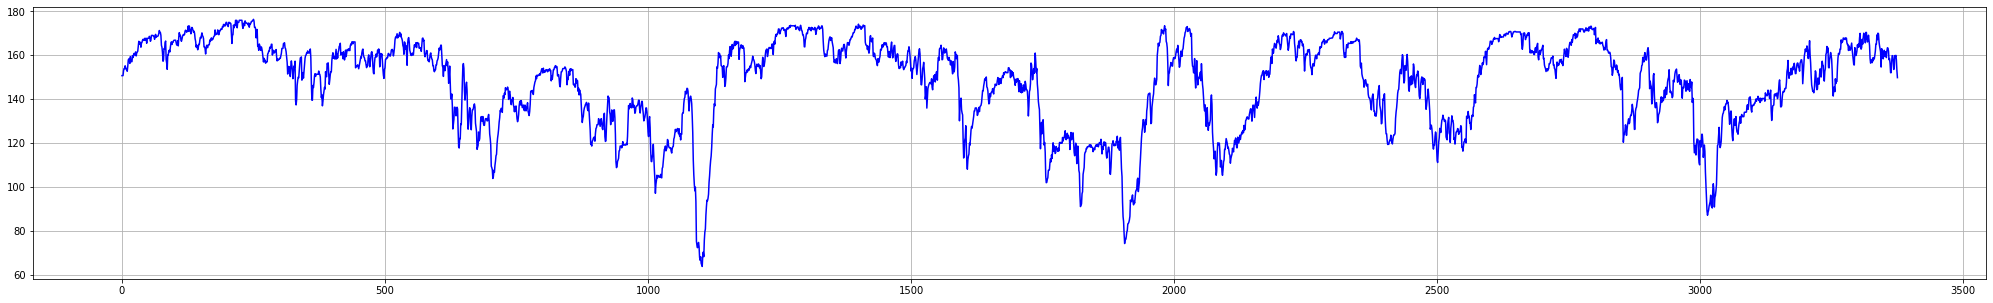

In [41]:
plt.rcParams["figure.figsize"] = (35,5)
plt.plot(distances_1, "b")
plt.grid()
plt.show()

In [ ]:
distances_2 = find_head_tail_distances_from_images(frames_paths = frames_paths[1], high_gray = 110 )

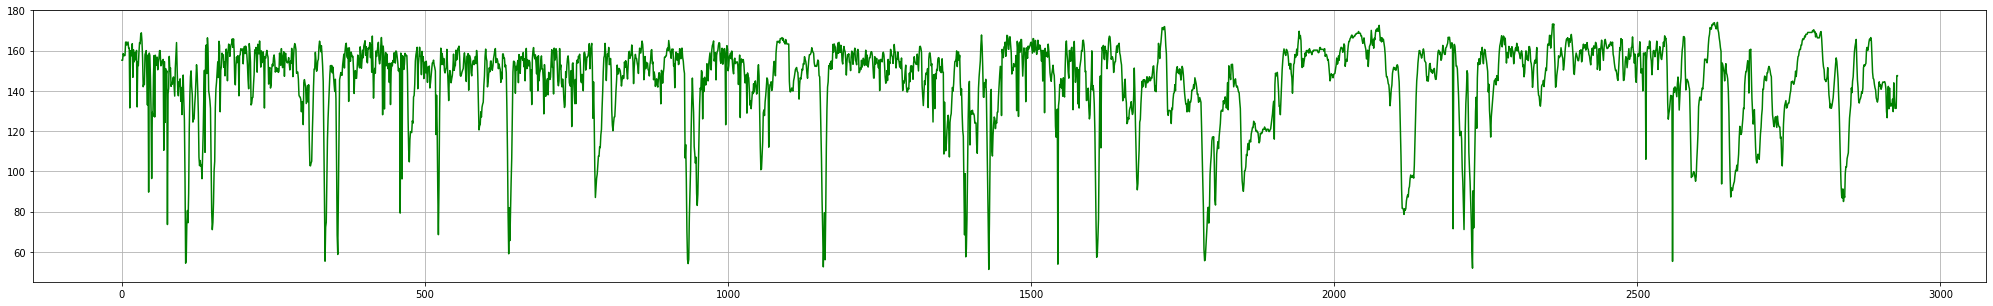

In [43]:
plt.plot(distances_2, "g")
plt.grid()
plt.show()

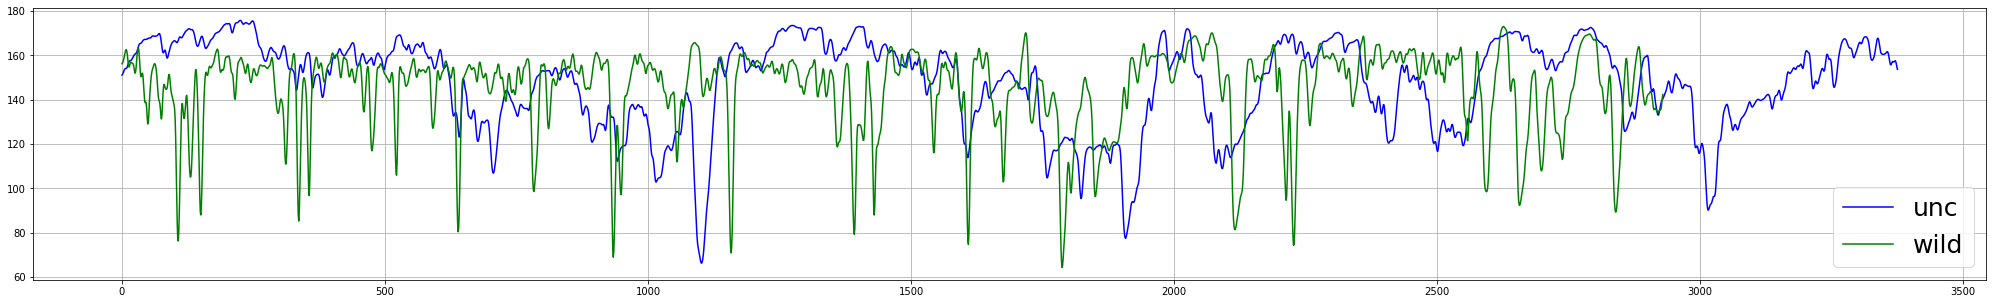

In [44]:
from scipy.ndimage.filters import gaussian_filter1d   ## smoother

d1 = gaussian_filter1d(distances_1, sigma = 2)
d2 = gaussian_filter1d(distances_2, sigma = 2)

plt.plot(d1,"b", label = "unc")
plt.plot(d2, "g", label = "wild")
plt.legend(fontsize=25)
plt.grid()
plt.show()

In [0]:
os.mkdir(ROOT + "time_series_data")
np.savetxt(ROOT + "time_series_data/" "distances_unc.csv", distances_1)
np.savetxt(ROOT + "time_series_data/" "distances_wild.csv", distances_2)

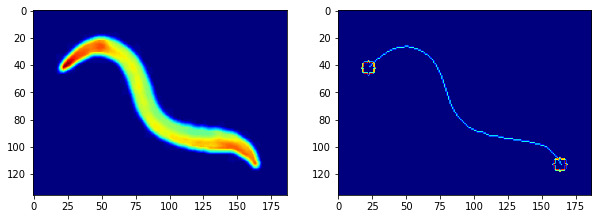

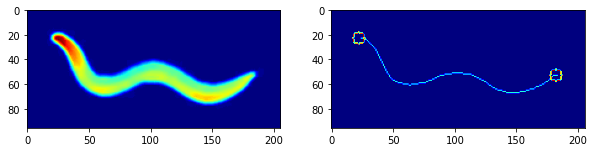

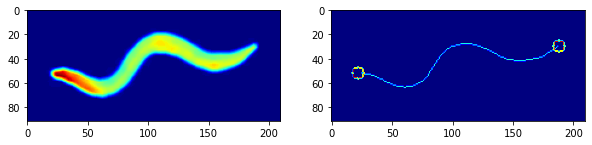

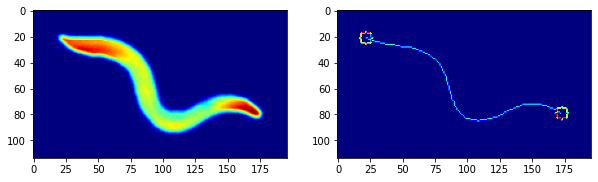

In [0]:

for i in range (0, len(filenames), 201):
    eroded_image = cv2.imread(filenames[i], 0)
    eroded_image = cv2.blur(eroded_image,(5,5)) 
    skeleton = generate_skeleton_from_eroded_image(eroded_image)
    fig, ax = plt.subplots(1,2, figsize = (10,10))

    ax[0].imshow( eroded_image, cmap = "jet")
    ax[1].imshow(skeleton, cmap = "jet")
    fig.show()